In [1]:
import os
import pickle
import itertools

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch
import torch.nn.functional as F

In [2]:
epochs = 300
model_path = "/u/home/s/skirti/project-mdipoppa/thalamocortical-expansion/01_data/models"

data_name = "triplet_digits_2"
embedding_dims = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
margins = [3., 4., 5.]

In [3]:
hyper_params = []

for ed, margin in itertools.product(embedding_dims, margins):
    margin_str = f"{margin:.1f}".replace('.', 'p')
    hyper_path = f"{model_path}/class_{data_name}_hyper_M{margin_str}_V1{ed}_EP{epochs}.pkl"

    if not os.path.exists(hyper_path):
        print(f" File not found: {hyper_path}")
        continue

    with open(hyper_path, 'rb') as f:
        saved = pickle.load(f)
    
    hyper_params.append({
        "model id": saved["model id"],
        "learning rate": saved["learning_rate"],
        "weight decay": saved["weight_decay"],
        "batch size": saved["batch_size"],
        "embedding dim": saved["v1_neurons"],  
        "l1 lambda": saved["l1_lambda"],
        "epochs": saved["epochs"],  
        "margin": saved["margin"],  
        "patience": saved["patience"],
        "min delta": saved["min_delta"],
        })
n_models = len(hyper_params)

In [4]:
results = []

for hp in hyper_params:  # assuming hyper_params is a list of dicts with 'hidden dim' and 'embedding dim'
    margin = hp['margin']
    embedding_dim = hp['embedding dim']
    margin_str = f"{margin:.1f}".replace('.', 'p')
    filename = f"{model_path}/class_{data_name}_meta_M{margin_str}_V1{embedding_dim}_EP{epochs}.pkl"
    if not os.path.exists(filename):
        print(f" File not found: {filename}")
        continue
    with open(filename, 'rb') as f:
        saved_train = pickle.load(f)
        
    filename = f"{model_path}/class_test_{data_name}_M{margin_str}_V1{embedding_dim}_EP{epochs}.pkl"
    if not os.path.exists(filename):
        print(f" File not found: {filename}")
        continue
    with open(filename, 'rb') as f:
        saved_test = pickle.load(f)

    results.append({
        "train_losses": saved_train["train_losses"],
        "val_losses": saved_train["val_losses"],
        "train_viol": saved_train["train_viol"],
        "val_viol": saved_train["val_viol"],
        "train_time": saved_train["train_time"],
        "best_epoch": saved_train["best_epoch"],
        "test_losses": saved_test["test_loss"],
        "test_viol": saved_test["test_viol"],
        "test_gini": saved_test["test_gini"],
    })

print(f"✅ Loaded {len(results)} models from disk")

✅ Loaded 30 models from disk


In [5]:
# --- Get all unique margins ---
margins = sorted(set(hp["margin"] for hp in hyper_params))

best_m_id = []

print("\n Best model for each margin:")
for m in margins:
    # All models with this margin
    margin_ids = [i for i, hp in enumerate(hyper_params) if hp["margin"] == m]
    
    # Pick the one with minimum validation loss
    best_id = min(margin_ids, key=lambda i: min(results[i]["val_losses"]))
    best_m_id.append(best_id)
    
    # Print summary for this margin
    best_loss = min(results[best_id]["val_losses"])
    ed = hyper_params[best_id]['embedding dim']
    print(f"Margin={m}: Model ID={best_id}, ED={ed}, Best Validation Loss={best_loss:.4f}")


 Best model for each margin:
Margin=3.0: Model ID=12, ED=512, Best Validation Loss=1.2507
Margin=4.0: Model ID=7, ED=128, Best Validation Loss=1.6638
Margin=5.0: Model ID=14, ED=512, Best Validation Loss=2.0701


In [6]:
# --- Sort and pick best based on early stopping ---
best_id = min(range(len(results)), key=lambda i: min(results[i]["val_losses"]))
best_result = results[best_id]
best_hyperparams = hyper_params[best_id]
best_val_loss = min(best_result["val_losses"])
best_val_viol = min(best_result["val_viol"])

print("\n Best config:")
print(f"   ED={best_hyperparams['embedding dim']}, "
    f"M={best_hyperparams['margin']}")
print(f"   Best Validation Loss={best_val_loss:.4f}")
print(f"   Training Time: {best_result['train_time']:.2f} sec")


 Best config:
   ED=512, M=3.0
   Best Validation Loss=1.2507
   Training Time: 308.73 sec


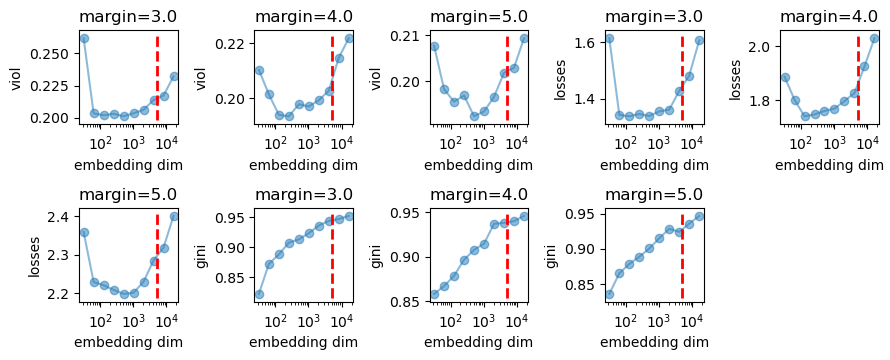

In [7]:
metric_i = ["viol","losses","gini"]
embedding_exp = ['1/8', '1/4', '1/2', '1', '2', '4']
hidden_exp = ['1/8', '1/4', '1/2', '1', '2', '4', '8', '16', '32']
#metric = "viol"
#metric = "losses"
#metric = "gini"
mouse_exp = 20*16*16
human_exp = 300*16*16

xvar = 'embedding dim'
yvar = 'margin'
xvals = sorted(set(r[xvar] for r in hyper_params))
yvals = sorted(set(r[yvar] for r in hyper_params))

# Define styles
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
yvals_to_color = {ed: colors[i % len(colors)] for i, ed in enumerate(yvals)}

# Plot
plt.figure(figsize=(9, 5))
ip = 0
for metric in metric_i:
    
    
    xval_array = np.array(xvals)

    for yval in yvals:
        ip += 1
        plt.subplot(3,5,ip)

        test_losses = []
        for xval in xvals:
            model_id = next(i for i, r in enumerate(hyper_params)
                            if r[xvar] == xval and r[yvar] == yval)

            test_losses.append(results[model_id]['test_'+metric])

        color = yvals_to_color[yval]
        label = f"{yvar}={yval}"
        plt.plot(xval_array, test_losses, 'o-',label=label,alpha=0.5)
        yl = plt.ylim()  # get current y-axis limits
        plt.plot(mouse_exp*np.ones(2), yl, '--r', linewidth=2)  # vertical line at x=3
        #plt.plot(human_exp*np.ones(2), yl, '-.g', linewidth=2)  # vertical line at x=7
        # Formatting
        plt.xscale("log")
        plt.xlabel(xvar)
        plt.ylabel(metric)
        plt.title(label)
        #plt.legend()
        plt.tight_layout()
#plt.savefig('figures/test_results.png')

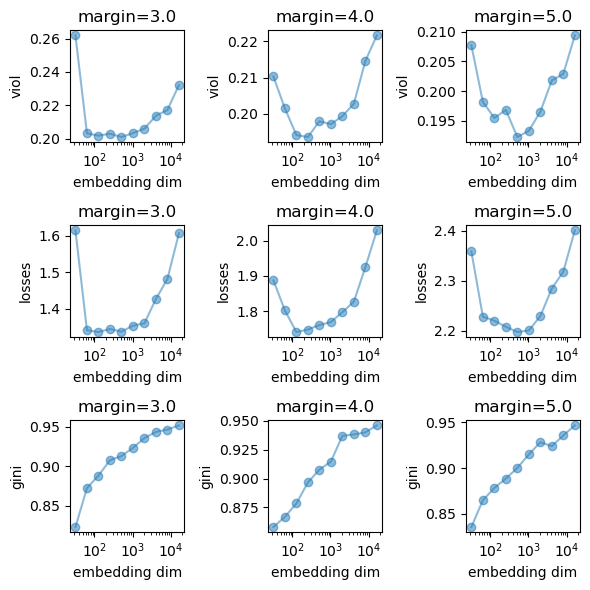

In [8]:
metric_i = ["viol","losses","gini"]
#metric = "viol"
#metric = "losses"
#metric = "gini"
mouse_exp = 20*16*16
human_exp = 300*16*16

xvar = 'embedding dim'
yvar = 'margin'
xvals = sorted(set(r[xvar] for r in hyper_params))
yvals = sorted(set(r[yvar] for r in hyper_params))
nx = len(xvals)
ny = len(yvals)
nm = len(metric_i)

# Define styles
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
yvals_to_color = {ed: colors[i % len(colors)] for i, ed in enumerate(yvals)}

# Plot
plt.figure(figsize=(ny*2, nm*2))
ip = 0
for metric in metric_i:
    
    
    xval_array = np.array(xvals)

    for yval in yvals:
        ip += 1
        plt.subplot(nm,ny,ip)

        test_losses = []
        for xval in xvals:
            model_id = next(i for i, r in enumerate(hyper_params)
                            if r[xvar] == xval and r[yvar] == yval)

            test_losses.append(results[model_id]['test_'+metric])

        color = yvals_to_color[yval]
        label = f"{yvar}={yval}"
        plt.plot(xval_array, test_losses, 'o-',label=label,alpha=0.5)
        yl = plt.ylim()  # get current y-axis limits
        #plt.plot(mouse_exp*np.ones(2), yl, '--r', linewidth=2)  # vertical line at x=3
        
        # Formatting
        plt.xscale("log")
        plt.xlabel(xvar)
        plt.ylabel(metric)
        plt.title(label)
        #plt.legend()
        plt.tight_layout()
#plt.savefig(f'figures/test_results_{data_name}.png')

In [9]:
# Extract unique values
hds = sorted(set(r['margin'] for r in hyper_params))
eds = sorted(set(r['embedding dim'] for r in hyper_params))

n_hds = len(hds)
n_eds = len(eds)




hd_array = np.array(hds)
ed_array = np.array(eds)

test_loss = np.zeros((n_eds,n_hds))
test_viol = np.zeros((n_eds,n_hds))
test_gini = np.zeros((n_eds,n_hds))
best_epoch = np.zeros((n_eds,n_hds),dtype=int)
train_time = np.zeros((n_eds,n_hds))
for ied,ed in enumerate(eds):
    
    val_losses = []
    for ihd,hd in enumerate(hds):
        model_id = next(i for i, r in enumerate(hyper_params)
                        if r['embedding dim'] == ed and 
                        r['margin'] == hd)

        test_loss[ied,ihd] = results[model_id]['test_losses']
        test_viol[ied,ihd] = results[model_id]['test_viol']
        test_gini[ied,ihd] = results[model_id]['test_gini']
        best_epoch[ied,ihd] = results[model_id]['best_epoch']
        train_time[ied,ihd] = results[model_id]['train_time']

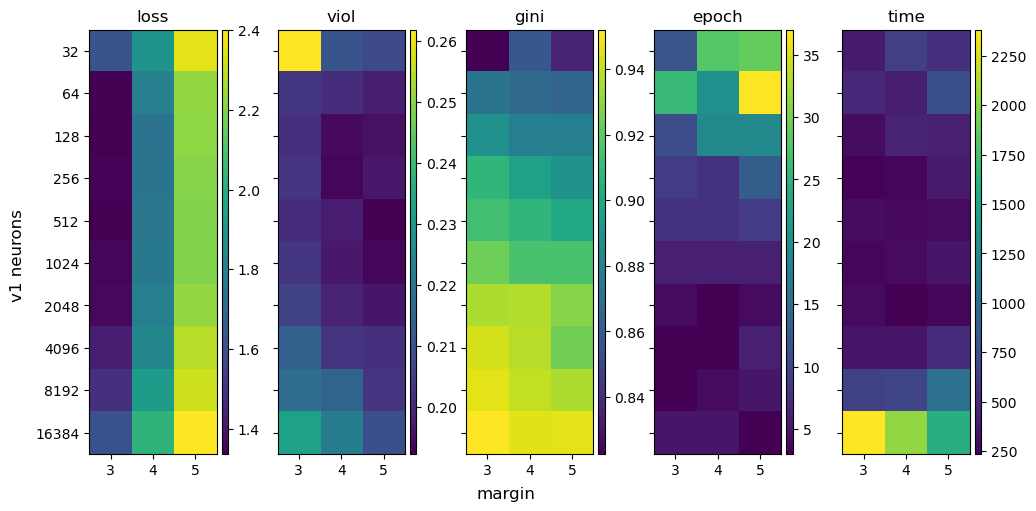

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# let's take a look at what these look like
metrics = ["loss", "viol", "gini", "epoch", "time"]
fig, ax = plt.subplots(1, 5, figsize=(10,5), sharex=True, sharey=True, layout="constrained")

for i,metric in enumerate([test_loss, test_viol, test_gini, best_epoch, train_time]):
    im = ax[i].imshow(metric)
    ax[i].set_xticks([0,1,2], [3,4,5])
    ax[i].set_yticks(np.arange(10), ed_array)
    ax[i].set_title(metrics[i])
    
    # colorbar
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
  
fig.supxlabel("margin")
fig.supylabel("v1 neurons") 

plt.show()

In [11]:
def rearrange_blocks_fixed(blocks, p, q):
    m, n1, n2 = blocks.shape
    assert n1 == n2, "Blocks must be square"
    assert m == p * q, "m must equal p * q"
    n = n1
    reshaped = blocks.reshape(p, q, n, n)
    merged = reshaped.swapaxes(1, 2).reshape(p * n, q * n)
    return merged

In [12]:
def resmooth_weights(model, sigma=0.25):
    weight = model.fc.weight.data
    emb_dim = weight.shape[0]
    weight_reshaped = weight.view(emb_dim, 1, 16, 16)

    kernel_size = int(2 * round(3 * sigma) + 1)
    kernel = gaussian_kernel2d(kernel_size, sigma, device=weight.device)
    kernel = kernel.view(1, 1, kernel_size, kernel_size)

    smoothed = F.conv2d(weight_reshaped, kernel, padding=kernel_size // 2)
    model.fc.weight.data.copy_(smoothed.view(emb_dim, -1))

In [13]:



class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=32):
        super().__init__()
        self.fc = nn.Linear(16*16, embedding_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        out = self.relu(self.fc(x))  # Linear followed by ReLU
        return out

In [14]:
def gaussian_kernel2d(kernel_size=5, sigma=0.25, device='cpu'):
    ax = torch.arange(kernel_size, device=device) - kernel_size // 2
    xx, yy = torch.meshgrid(ax, ax, indexing="xy")
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load best model
weights_reshaped = []
for model_id in range(n_models):

    ed = hyper_params[model_id]["embedding dim"]

    margin = hyper_params[model_id]["margin"]
    margin_str = f"{margin:.1f}".replace('.', 'p')
    model_file = f"{model_path}/class_{data_name}_weights_M{margin_str}_V1{ed}_EP{epochs}.pt"
    model = EmbeddingNet(embedding_dim=ed)
    model.load_state_dict(torch.load(model_file))
    model.to(device)
    model.eval()

    # ---- Smooth the weights again ----
    resmooth_weights(model, sigma=.5)

    # Extract weights from first layer (input to hidden): shape (n_hidden_units, 256)
    first_layer = model.fc  # Replace if you used a different name
    weights = first_layer.weight.detach().cpu().numpy()  # shape: (n_hidden_units, 256)

    # Reshape to (n_hidden_units, 16, 16)
    weights_reshaped.append(weights.reshape(weights.shape[0], 16, 16))

    #print("Weight shape:", weights_reshaped[model_id].shape)  # (n_hidden_units, 16, 16)

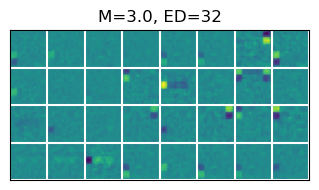

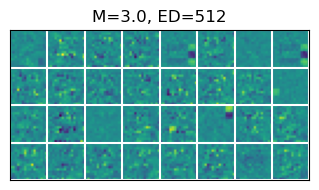

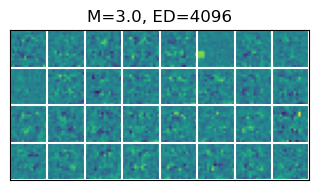

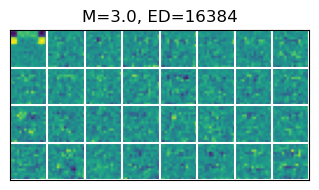

In [16]:
n = 16
p = 4 # rows 
q = 8 # columns
size_factor = 0.5
for model_id in range(n_models):
    
    embedding_dim = hyper_params[model_id]['embedding dim']
    margin = hyper_params[model_id]['margin']
    # ---- Filter ----
    if margin != 3.0 or embedding_dim not in [32, 512, 4096, 16384]:
        continue  # skip models that don't match criteria
    
    merged_rf = rearrange_blocks_fixed(weights_reshaped[model_id][:32,:,:], p=p, q=q)
    plt.figure(figsize=(q*size_factor,p*size_factor))
    plt.imshow(merged_rf)
    for i in range(q+1):
        plt.plot(i*n*np.ones(2)-0.5,np.array([0,n*p])-0.5,'w')
    for i in range(p+1):
        plt.plot(np.array([0,n*q])-0.5,i*n*np.ones(2)-0.5,'w')
    plt.xticks([])
    plt.yticks([])
    embedding_dim = hyper_params[model_id]['embedding dim']
    margin = hyper_params[model_id]['margin']
    #lambda_str = "0" if l1_lambda == 0 else f"{l1_lambda:.0e}".replace('-', 'm')
    plt.title(f"M={margin}, ED={embedding_dim}")
    
    plt.tight_layout()
    plt.savefig(f'figures/RF_ED{embedding_dim}.pdf')

In [17]:
anchors_np = np.load(f'{model_path}/anchors_data_{data_name}.npy')
print("Shape:", anchors_np.shape)

Shape: (20000, 256)


In [18]:
# Load
data = np.load(f"{model_path}/emb_act_data_{data_name}_EP{epochs}.npz")
emb_act = [data[f"arr_{i}"] for i in range(len(data.files))]
print(emb_act[0].shape)

(20000, 32)


In [19]:
margin = 3.
ed = 1024

model_id = next(i for i, r in enumerate(hyper_params)
                if r["embedding dim"] == ed and
                r["margin"] == margin)
print(model_id)
print(emb_act[model_id].shape)

ed = 32
model_id_32 = next(i for i, r in enumerate(hyper_params)
                if r["embedding dim"] == ed and
                r["margin"] == margin)
print(model_id_32)
print(emb_act[model_id_32].shape)

15
(20000, 1024)
0
(20000, 32)


In [20]:
from sklearn.decomposition import PCA

# --- Fit PCA ---
pca0 = PCA(n_components=2)  # 2D projection
pca0.fit(anchors_np)  # shape: (20000, 2)
anchors_pca = pca0.transform(anchors_np)  # shape: (20000, 2)

# --- Explained variance ---
print("Explained variance ratio:", pca0.explained_variance_ratio_)
print("Total variance explained:", pca0.explained_variance_ratio_.sum())

# --- Fit PCA ---
pca32 = PCA(n_components=2)  # 2D projection
pca32.fit(emb_act[model_id_32])  # shape: (20000, 2)
emb_pca32 = pca32.transform(emb_act[model_id_32])  # shape: (20000, 2)

# --- Explained variance ---
print("Explained variance ratio:", pca32.explained_variance_ratio_)
print("Total variance explained:", pca32.explained_variance_ratio_.sum())

# --- Fit PCA ---
pca = PCA(n_components=2)  # 2D projection
pca.fit(emb_act[model_id])  # shape: (20000, 2)
emb_pca = pca.transform(emb_act[model_id])  # shape: (20000, 2)

# --- Explained variance ---
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Explained variance ratio: [0.21057798 0.17793684]
Total variance explained: 0.38851482
Explained variance ratio: [0.1322428  0.12260715]
Total variance explained: 0.25484994
Explained variance ratio: [0.08918543 0.07872267]
Total variance explained: 0.1679081


In [21]:
test_labels = np.load(f'{model_path}/test_labels_{data_name}.npy')

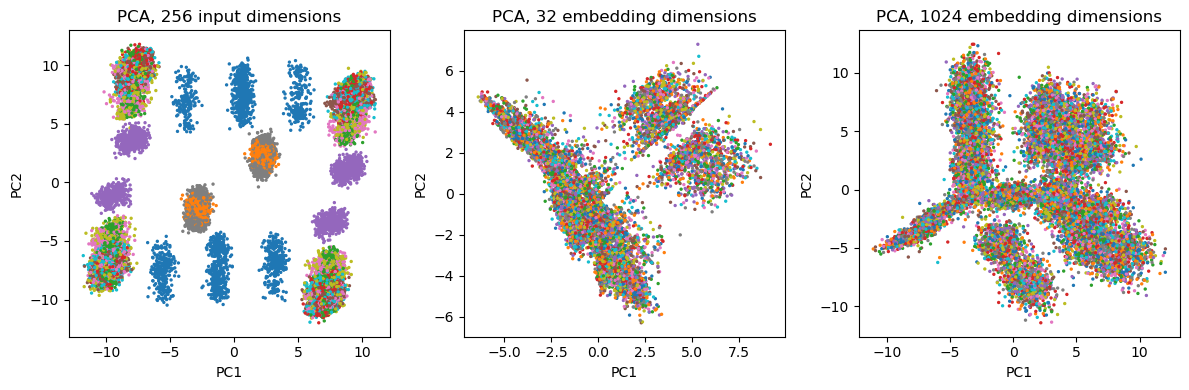

In [22]:
# --- Plot ---
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
scatter = plt.scatter(anchors_pca[:, 0], anchors_pca[:, 1], 
                      c=test_labels, cmap="tab10", s=2)
#plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA, 256 input dimensions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()

plt.subplot(1,3,2)
scatter = plt.scatter(emb_pca32[:, 0], emb_pca32[:, 1], 
                      c=test_labels, cmap="tab10", s=2)
#plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA, 32 embedding dimensions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()

plt.subplot(1,3,3)
scatter = plt.scatter(emb_pca[:, 0], emb_pca[:, 1], 
                      c=test_labels, cmap="tab10", s=2)
#plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA, 1024 embedding dimensions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()

plt.savefig(f'figures/PCA_{data_name}_M{margin_str}_ED{ed}.pdf')

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [24]:
def create_split_indices(n_samples, val_size=0.2, test_size=0.2, random_state=42):
    # First split train+val and test
    train_val_idx, test_idx = train_test_split(np.arange(n_samples),
                                               test_size=test_size,
                                               random_state=random_state,
                                               shuffle=True)
    # Split train and val
    train_idx, val_idx = train_test_split(train_val_idx,
                                          test_size=val_size/(1-test_size),
                                          random_state=random_state,
                                          shuffle=True)
    return train_idx, val_idx, test_idx

In [ ]:
def train_softmax_classifier_pre_split(X_train, y_train, X_val, y_val,
                                       lr=1e-3, weight_decay=1e-3,
                                       epochs=2000, patience=20):
    """
    Train a linear softmax classifier using pre-split data.
    """
    # ---- Ensure tensors and correct dtypes ----
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train, dtype=torch.float32)
    else:
        X_train = X_train.float()

    if not isinstance(X_val, torch.Tensor):
        X_val = torch.tensor(X_val, dtype=torch.float32)
    else:
        X_val = X_val.float()

    if not isinstance(y_train, torch.Tensor):
        y_train = torch.tensor(y_train, dtype=torch.long)
    else:
        y_train = y_train.long()

    if not isinstance(y_val, torch.Tensor):
        y_val = torch.tensor(y_val, dtype=torch.long)
    else:
        y_val = y_val.long()

    # ---- Model, Loss, Optimizer ----
    model = LinearSoftmax(X_train.shape[1], len(torch.unique(y_train)))
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    # ---- Tracking ----
    history = {
        "val_loss": [], "val_acc": [],
        "train_loss": [], "train_acc": []
    }
    
    best_val_loss = float('inf')
    best_state = None
    wait = 0

    for epoch in range(epochs):
        # --- Train ---
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss = loss.item()
        train_pred = outputs.argmax(dim=1)
        train_acc = (train_pred == y_train).float().mean().item()

        # --- Validation ---
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            val_pred = val_outputs.argmax(dim=1)
            val_acc = (val_pred == y_val).float().mean().item()

        # ---- Store metrics ----
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # --- Early stopping ---
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch+1}/{epochs}, "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history

In [ ]:
class LinearSoftmax(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)  # softmax handled by loss function

In [ ]:
def evaluate_model(model, X_test, y_test):
    """
    Compute test loss and accuracy for a trained model.
    """
    # Ensure correct tensor types
    if not isinstance(X_test, torch.Tensor):
        X_test = torch.tensor(X_test, dtype=torch.float32)
    else:
        X_test = X_test.float()

    if not isinstance(y_test, torch.Tensor):
        y_test = torch.tensor(y_test, dtype=torch.long)
    else:
        y_test = y_test.long()

    criterion = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        loss = criterion(outputs, y_test).item()
        preds = outputs.argmax(dim=1)
        acc = (preds == y_test).float().mean().item()

    return loss, acc